# База "ключ-значение" Redis

Документация на обертку для Питона находится [здесь](https://redis-py.readthedocs.io/en/stable/genindex.html).

Установим саму базу данных и redis-py (`pip3 install redis`). Помимо этого установим библиотеку hiredis (`pip3 install hiredis`), которая обрабатывает ответ от БД несколько быстрее.


# !!! Можно итерироваться по шаблону !!!

for el in r.hscan_iter(value, match='snow_?'):  
  print(el)
  
for el in r.scan_iter(value, match='snow_?'): # Тут как-то по-другому, но функция эта.  
  print(el)

In [1]:
!pip3 install redis
!pip3 install hiredis

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
# Импортируем драйвер к Redis.
import redis

Присоединяемся к базе данных. По умолчанию она работает только с локальной машиной, аутентификация не предусмотрена.

На самом деле, параметры можно не указывать, ниже передаются те же самые значения, что принимаются по умолчанию.

In [8]:
r = redis.Redis(host='localhost', port=6379, db=0)

Очистим базу, чтобы нам ничего не мешало.

In [9]:
r.flushdb()

True

Код в ячейке ниже поможет нам визуализировать нашу работу с Redis.

In [10]:
from ipywidgets import HTML
from IPython.display import display#, HTML

def show_redis_data(r):
    html = HTML()
    out = '<table border="1">'
    for key in r.keys():
        t = r.type(key).decode()
#         print(key.decode(), t)
        
        if t == 'string':
            data = r.get(key)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">string</td>'\
                   f'<td style="padding:3px;">{data.decode()}</td></tr>'
        elif t == 'list':
            l = r.llen(key)
            data = r.lrange(key, 0, l)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">list</td>'\
                   f'<td style="padding:3px;">[{", ".join([d.decode() for d in data])}]</td></tr>'
        elif t == 'hash':
            data = []
            for key2 in r.hkeys(key):
                data.append(f'{key2.decode()}: {r.hget(key, key2).decode()}')
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">hash</td>'\
                   f'<td style="padding:3px;">{{{", ".join(data)}}}</td></tr>'
        elif t == 'set':
            data = r.smembers(key)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">set</td>'\
                   f'<td style="padding:3px;">({", ".join([d.decode() for d in data])})</td></tr>'
        
    out += '</table>'
    
    html.value = out
    display(html)


### Работа с простыми ключами

В некотором роде, Redis является словарем, к которому приделали интерфейс базы данных и массу дополнительных возможностей.

Попробуем положить в него какой-нибудь ключ...

In [11]:
show_redis_data(r)

HTML(value='<table border="1"></table>')

In [12]:
r.set('foo', 'bar2')
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">foo</td><td style="padding:3px;width:50…

... и получить его обратно.

In [13]:
r.get('foo')

b'bar2'

Обратите внимание, что все данные превращаются в строки, хотя мы можем присваивать их как числа.  
Также обратите внимание, что если Redis находит ключ, то он заменяет его значение, а если не находит, то заводит в базе новый ключ и связывает с ним значение.

In [14]:
ttt = r.get('foo')

In [15]:
ttt.decode()

'bar2'

In [16]:
r.set('foo', 100)
print(r.get('foo'), type(r.get('foo')))
print(int(r.get('foo')))
r.set('another one', 200)

show_redis_data(r)

b'100' <class 'bytes'>
100


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">another one</td><td style="padding:3px;…

При помощи функции `keys` можно посмотреть все ключи в базе. Функция `flushdb` очищает текущую базу.

In [17]:
r.keys()

[b'another one', b'foo']

### Работа со списками

Помимо работы с простыми строками, Redis позволяет организовывать список, привязанный к определенному ключу. При помощи функций `rpush` и `lpush` можно класть значения в очередь с заданным ключем.

In [18]:
r.set('test1', 1) # Просто, чтобы было видно отличие.
r.lpush('test2', 2) # Первый элемент.
r.rpush('test2', 3) # Следующий кладется справа.
r.lpush('test2', 4) # Следующий кладется слева.
r.rpush('test2', 5) # Последний кладется справа.
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">another one</td><td style="padding:3px;…

In [19]:
ttt = r.rpop('test2')
print(ttt)
show_redis_data(r)

b'5'


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">another one</td><td style="padding:3px;…

In [20]:
# Можно в одну операцию достать элемент и тот же положить его обратно.
d = r.rpoplpush('test2', 'test2')
print(d)
show_redis_data(r)

b'3'


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">another one</td><td style="padding:3px;…

In [21]:
r.llen('test2')

3

Скажем, у нас есть кормушки для щенков

In [53]:
for address, amount in zip(['puppy5', 'puppy4', 'puppy3', 'puppy2', 'puppy1'],
                            [100, 50, 39, 67, 83]):
    r.rpush('adress', address)
    r.rpush('amount', amount)

In [54]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">test2</td><td style="padding:3px;width:…

In [64]:
for key in r.scan_iter('a*', _type='list'):
    print(key)

b'amount'
b'adress'


In [63]:
r.type('amount')

b'list'

In [37]:
while r.exists('adress'):
    whom = r.lpop('adress')
    amount = r.lpop('amount')
    print(f'feeding {whom}, {amount}')

feeding b'puppy5', b'100'
feeding b'puppy4', b'50'
feeding b'puppy3', b'39'
feeding b'puppy2', b'67'
feeding b'puppy1', b'83'


### Хеш-массивы

Redis умеет привязывать к ключу хешированный массив - аналог питоновского словаря. Запись одного значения производится по паре ключ-ключ внутри хеша при помощи `hset`, чтение - аналогично при помощи `hget`.


In [65]:
r.flushdb()
r.hset('asdf', '1', '200')
r.hset('asdf', '2', '201')

1

In [66]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">asdf</td><td style="padding:3px;width:5…

In [67]:
r.hget('asdf', '2')

b'201'

Как и в случае со скалярными значениями, найденный ключ перезаписывается.

In [68]:
r.hset('asdf', '2', '301')

show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">asdf</td><td style="padding:3px;width:5…

Проверить наличие ключа в хеше можно при помощи функции `hexists`.

In [69]:
r.get('asdf444'), r.hget('asdf', '33')

(None, None)

In [70]:
r.get('asdf444'), r.exists('asdf444'), r.hexists('asdf444', '33')

(None, 0, False)

In [75]:
puppies = {'puppy1': {'name': 'Jack', 'age': 1.2, 'weight': 15}, 
           'puppy2': {'name': 'Jooly', 'age': 0.8, 'weight': 1.5}, 
           'puppy3': {'name': 'Jackil', 'age': 1.5, 'weight': 5.3}}

for _id, desc in puppies.items():
    r.rpush('puppy_names', _id)
    for key, val in desc.items():
        r.hset(_id, key, str(val))

In [76]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">puppy_names</td><td style="padding:3px;…

In [77]:
for ident in ['puppy1', 'puppy2', 'puppy3']:
    print(r.hget(ident, 'name').decode())

Jack
Jooly
Jackil


In [80]:
for i in range(r.llen('puppy_names')):
    ident = r.rpoplpush('puppy_names', 'puppy_names')
    print(r.hget(ident, 'name').decode())

Jackil
Jooly
Jack


In [83]:
r.flushdb()

True

In [85]:
for _id, desc in puppies.items():
    r.rpush('puppy_names', _id)
    r.hset(_id, mapping=desc)

In [86]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">puppy3</td><td style="padding:3px;width…

А еще Redis умеет работать с [JSON](https://redis-py.readthedocs.io/en/stable/redismodules.html#redisjson-commands).

### Множества

Помимо этого, к ключу можно привязать множество. Добавление в множество ведется при помощи операции `sadd`. Также можно находить пересечение (`sinter`), объединение (`sunion`)  разницу (`sdiff`) множеств.

In [87]:
r.flushdb()

True

In [88]:
r.sadd("testSets1", "A")
r.sadd("testSets1", "A")
r.sadd("testSets1", "A")
r.sadd("testSets1", "B")
r.sadd("testSets1", "C")

r.sadd("testSets2", "A")
r.sadd("testSets2", "D")
r.sadd("testSets2", "F")

print('intersection:', r.sinter(["testSets1","testSets2"]))

show_redis_data(r)

intersection: {b'A'}


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets1</td><td style="padding:3px;wi…

Результаты операций над множествами можно сохранить в другое множество.

In [89]:
r.sdiffstore("testSets4", ["testSets1", "testSets2"])
r.sunionstore("testSets3", ["testSets1", "testSets2"])
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets1</td><td style="padding:3px;wi…

Элемент можно атомарно перебросить из одного множества в другое при помощи `smove`.

In [90]:
r.smove("testSets2", "testSets1", 'F')
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets1</td><td style="padding:3px;wi…

 Удалить значение можно при помощи `srem`, узнать длину множества - `scard`.

In [91]:
r.srem("testSets1", 'F')
show_redis_data(r)
print(r.scard("testSets1"))

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets1</td><td style="padding:3px;wi…

3


In [92]:
for i in range(r.llen('puppy_names')):
    ident = r.lpop('puppy_names')
    r.rpush('puppy_names', ident)
    r.sadd('puppy_names_set', r.hget(ident, 'name'))
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets1</td><td style="padding:3px;wi…

In [ ]:
000
001
010
011
100
101
110
111

f & 11100000000 >> 7

  0010011000
& 1110000000
  0000000001

  0010011000
& 0001110000
  0000010000 >> 4
  0000000001

А еще у Redis замечательные [битовые операции](https://blog.getspool.com/2011/11/29/fast-easy-realtime-metrics-using-redis-bitmaps/) и отсортированные списки.

### Последовательности команд и имитация транзакций

Каждая команда возвращает объект типа `pipeline`. Данный объект позволяет выполнять транзакции. Для этого необходимо при помощи pipeline выполнить несколько команд (они будут поставлены во внутреннюю очередь), а затем вызвать `execute`. Таким образом поддерживаются транзакции для нескольких команд, не требующих промежуточного чтения результатов.

В итоге вернется список результатов выполнения команд.

In [93]:
pipe = r.pipeline()
pipe.srem("testSets1", 'A')
pipe.sadd("testSets1", 'G')
pipe.smembers("testSets1")
pipe.execute()

[1, 1, {b'B', b'C', b'G'}]

In [94]:
r.pipeline().srem("testSets2", 'A').sadd("testSets1", 'R').smembers("testSets1").execute()

[1, 1, {b'B', b'C', b'G', b'R'}]

Если в промежутках необходимо модифицировать какие-то значения, следует использовать следующую конструкцию. В ней `watch` говорит, что мы будем следить за заданным ключем. Команда `multi` говорит о том, что сейчас будет выполняться несколько операций как транзакция. Если значение, связанное с ключем в `watch` изменилось до начала `execute` (выполнение нескольких операций), то будет вызвано исключение.

In [95]:
ppp=r.pipeline()
ppp.multi()
ppp.set("dummy1", "1")
#ppp.multi()
ppp.set("dummy2", "1")
ppp.execute()

[True, True]

In [96]:
r.get("dummy1")

b'1'

Собственно транзакций в Redis не предусмотрено. Вместо этого можно подписаться на изменения какого-то ключа. Если ключ изменился в ходе наших вычислений, значит надо начать операцию заново. Довести операцию до конца получится только если прерывание не произошло, то есть никто не перезаписывал важные для нас данные.

In [97]:
r.set('OUR-SEQUENCE-KEY', 1)
with r.pipeline() as pipe:
    while 1:
        try:
            pipe.watch('OUR-SEQUENCE-KEY')
            current_value = pipe.get('OUR-SEQUENCE-KEY')
            next_value = int(current_value) + 1
            pipe.multi()
            pipe.set('OUR-SEQUENCE-KEY', next_value)
            pipe.execute()
            break
        except redis.WatchError:
            continue
            
r.get('OUR-SEQUENCE-KEY')

b'2'

### Автоматическое удаление ключей из базы по таймауту

Давайте пока посмотрим что Redis  умеет еще. Например, при помощи функции `expire` каждой паре можно сказать, что она утрачивает актуальность через какое-то время. 

Положим в базу 100 000 ключей, каждому из них установим время жизни 10 секунд, уснём на 15 секунд и посмотрим что осталось в базе.

In [98]:
from time import sleep

In [99]:
r.flushdb()

for i in range(100000):
    r.set(i, i)
    r.expire(i, 10)

sleep(15)

summ = 0
for k in r.keys():
    summ += int(r.get(k))
    
print(r.dbsize(), summ)

0 0


In [100]:
print(r.get(99999))

None


Как видно, не осталось ничего. Метод работает.

### Блокирующие операции в Redis

Redis поддерживает блокирующие операции. При помощи `brpop` и `blpop` мы можем приостановить свои действия либо пока не будет получено значение, либо пока не пройдет заданный промежуток времени.

Если функция успешно получила значение, она вернет его без дальнейшего ожидания. Если значение не было получено, то по истечении таймаута функция вернет None.

В примере ниже мы вынуждены сперва класть данные, а потом получать их без ожидания (ведь они уже есть в базе), так как мы работаем в один поток.

In [101]:
r.rpush("blockedTest", "asdf")
print(r.brpop("blockedTest", 1))

(b'blockedTest', b'asdf')


In [102]:
print(r.brpop("blockedTest", 5))
r.rpush("blockedTest", "asdf")


None


1

Для начала надо разобраться с тем, что такое потоки.

Библиотека multiprocessing обеспечивает настоящую параллельность выполнения потоков, но для каждого потока создает собственную копию интерпретатора. Чтобы запустить параллельные вычисления, необходимо создать функцию, которая и будет их выполнять. Затем, при помощи `multiprocessing.Process` можно создать параллельный поток, передав в параметр `target` название функции. Поток будет создан в приостановленном состоянии, запустить его можно при помощи функции `start`. Если необходимо подождать выполнения потока, нужно использовать функцию `join`.

In [103]:
import multiprocessing

In [104]:
val = 0

In [105]:
def func1():
    global val
    for i in range(10):
        print(f'1: {val}')
        val += 1
        sleep(0.2)
        
def func2():
    global val
    for i in range(10):
        print(f'2: {val}')
        val += 1
        sleep(0.3)

In [106]:
bpr1 = multiprocessing.Process(target=func1)
bpr2 = multiprocessing.Process(target=func2)
bpr1.start()
bpr2.start()
bpr1.join()
bpr2.join()

1: 0
2: 0
1: 1
2: 1
1: 2
1: 32: 2

1: 4
2: 3
1: 5
2: 41: 6

1: 7
2: 5
1: 8
2: 6
1: 9
2: 7
2: 8
2: 9


Если использовать multithreading или asyncio, то параллелилизм будет только имитироваться. Если поток засыпает, то управление передается другому потоку. Но если поток занимается вычислениями, то все ждут, когда он освободится, и только после этого управление может быть передано другому потоку.

Теперь запустим блокирующую операцию в два настоящих потока. Если один поток пишет, а второй читает, становится видно, что управление возвращается после ожидания в блокирующей функции.

Второй параметр функций `blpop` и `brpop` показывает, на в течение какого времени функция будет ожидать данных, после чего вернет управление. Если данные пришли до истечения таймаута, будут возвращены данные, в противном случае - None. Если данные не пришли, наша функция может проделать какие-то еще операции и вернуться к ожиданию.

In [107]:
r.flushdb()

True

In [108]:
# Функция ждет 5 секунд и только тогда пишет данные в базу.
def blockingWrite():
    sleep(5)
    r.lpush("blockedTest", "Yahooo!")
    
# Функция пытается читать данные, и если возвращается None (данные не пришли в течение таймаута),
# то она повторяет попытки до успешного чтения.
def blockingRead():
    bres = r.brpop("blockedTest", 1)
    while bres == None:
        print("waiting")
        bres = r.brpop("blockedTest", 1)
    print(bres)
    
bpr1 = multiprocessing.Process(target=blockingWrite)
bpr2 = multiprocessing.Process(target=blockingRead)
bpr1.start()
bpr2.start()
# Ждем окончания выполнения потоков только для того, чтобы пока не ходить дальше.
bpr1.join()
bpr2.join()

waiting
waiting
waiting
waiting
(b'blockedTest', b'Yahooo!')


---

## Замеры производительности Redis

Давайте потестируем производительность БД Redis, которая относится к базам "ключ-значение" и позиционируется как одна из самых быстрых баз данных. Авторы говорят о скорости больше миллиона обращений в секунду.

Скорость будем мерить при помощи дополнительной магии Юпитера - autotime. Теперь мне не придется писать `%%time`, а ячейка сама будет показывать, сколько времени прошло с момента запуска.

In [109]:
!pip install jupyter-autotime

Defaulting to user installation because normal site-packages is not writeable


In [110]:
%load_ext autotime

Померим скорость работы с базой при помощи такого простого метода, как `set`. Положим в базу 100 000 уникальных ключей, к которым привязано одно целое число.

In [111]:
!pip install bson

Defaulting to user installation because normal site-packages is not writeable


In [112]:
from bson import ObjectId

In [113]:
r.flushdb()

True

In [114]:
for i in range(100000):
    r.set(str(ObjectId()), i)

Примерно 12 000 операций вставки в секунду на локальной машине. Не так уж и много.

Посмотрим с какой скоростью они будут читаться.

In [115]:
summ=0
for k in r.keys():
    summ += int(r.get(k))

print("Всего ключей:", r.dbsize())

Всего ключей: 100000


Около 14 000 операций чтения.

Хм... Этот Redis, кажется, не такой уж и молодец.

Или мы что-то делаем не так? Давайте сравним с `dict`.

In [116]:
tst_dct={}
for i in range(100000):
    tst_dct[str(ObjectId())]=i

Примерно 600 000 операций записи в секунду...

In [117]:
summ=0
for k in tst_dct.keys():
    summ+=int(tst_dct[k])

... и примерно 7 млн операций чтения в секунду. Пока Redis очень далеко до `dict`.

Хотя dict не умеет отдавать данные нескольким программам одновременно.

Попробуем замерить скорость работы при помощи списков.

In [118]:
for i in range(100000):
    r.lpush('firstkey', i)
    r.lpush('secondkey', i)
    
print(r.keys()[:100])

[b'63c91046c5244e39f368e636', b'63c9104ac5244e39f369b755', b'63c91049c5244e39f369868e', b'63c91049c5244e39f36985bc', b'63c9104ac5244e39f3699175', b'63c9104ac5244e39f3699ea5', b'63c9104ac5244e39f369bb59', b'63c91048c5244e39f36934b7', b'63c91046c5244e39f368e921', b'63c91048c5244e39f3693f45', b'63c91049c5244e39f3697ae7', b'63c91044c5244e39f3687c14', b'63c9104bc5244e39f369c4ae', b'63c91046c5244e39f368d463', b'63c91048c5244e39f36947e3', b'63c9104ac5244e39f36992a6', b'63c91047c5244e39f368eee5', b'63c91049c5244e39f3698654', b'63c9104ac5244e39f369906d', b'63c91046c5244e39f368e62f', b'63c91047c5244e39f36912f3', b'63c91045c5244e39f36887a6', b'63c91047c5244e39f368f775', b'63c9104ac5244e39f3699a54', b'63c91049c5244e39f3696a71', b'63c91047c5244e39f3690c29', b'63c9104ac5244e39f369a7b7', b'63c91047c5244e39f368f597', b'63c91047c5244e39f368fbe7', b'63c91046c5244e39f368e878', b'63c91044c5244e39f3686075', b'63c91047c5244e39f368fdfb', b'63c91049c5244e39f3697147', b'63c91044c5244e39f36877fb', b'63c91049c52

Заодно проверим, может быть добавление ключей с другой стороны будет быстрее.

In [119]:
r.flushdb()

True

In [120]:
for i in range(100000):
    r.rpush('firstkey', i)
    r.rpush('secondkey', i)
    
print(r.keys())

[b'firstkey', b'secondkey']


Получается еще медленнее, чем при помощи `set`.

Извлекаем данные при помощи `lpop` и `rpop`. Как видно, получается тоже не быстро.

In [121]:
for i in range(100000):
    r.lpop('firstkey')
    r.lpop('secondkey')

Теперь попробуем пакетную запись значений. 

Может быть генерация ключей занимает больше времени, чем работа с БД? Отдельно сгенерируем идентификаторы для ключей, а потом положим их в базу.

In [122]:
objs = [str(ObjectId()) for i in range(100000)]

In [123]:
for i,x in enumerate(objs):
    r.set(x, i)

Быстрее не вышло. Может быть дело в for, и с помощью map мы сделаем всё быстрее?

In [124]:
_ = list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))

Убедимся, что мы не забыли сгенерировать новые ключи перед запуском предыдущей ячейки - проверим количество ключей в базу.

In [125]:
r.dbsize()

100000

Также убедимся, что работа со словарем всё еще быстрее. Кстати, значительно быстрее генерации ключей.

In [126]:
tst_dct = {}
for i in enumerate(objs):
    tst_dct[x] = i

Ключи в самом деле лежат в базе?

In [127]:
list(r.keys())[:10]

[b'63c9107bc5244e39f36b6f83',
 b'63c9107bc5244e39f36c4563',
 b'63c9107bc5244e39f36c027b',
 b'63c9107bc5244e39f36bac22',
 b'63c9107bc5244e39f36b774a',
 b'63c9107bc5244e39f36c4d67',
 b'63c9107bc5244e39f36c6a65',
 b'63c9107bc5244e39f36bc429',
 b'63c9107bc5244e39f36c3120',
 b'63c9107bc5244e39f36c2607']

### Пакетная запись в Redis

Попробуем функцию `mset`, которая кладет всё содержимое сформированного словаря одновременно.

In [128]:
objs = {str(ObjectId()):i for i in range(100000)}

In [129]:
r.mset(objs)

True

In [130]:
mkeys = list(r.keys())[:1000]

In [131]:
_ = r.mget(mkeys)

Получается в несколько раз быстрее - около 400 000 ключей в секунду на запись. Но это всё еще не похоже на миллион запросов в секунду.

### Замер производительности Redis в несколько потоков

Хорошо, может быть это Питон не справляется, а база может работать быстрее? Попробуем запустить несколько потоков, которые пишут в базу. Оформим генерацию ключей и загрузку ключей в базу как отдельную функцию, чтобы можно было ее запускать в параллельных потоках.

In [132]:
import multiprocessing

In [133]:
r.flushdb()

True

In [134]:
def putKey2Redis():
    objs = {str(ObjectId()):i for i in range(100000)}
    #_=list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))
    r.mset(objs)

In [135]:
pr = []

for i in range(10):
    p = multiprocessing.Process(target=putKey2Redis)
    p.start()
    pr.append(p)

for p in pr:
    p.join()

600 000 запросов в секунду. Явно улучшение не в 10 раз. Значит дело не только в Питоне. Но скорость уже впечатляющая. От обычной БД с настройками из коробки такую скорость не получишь.

Померяем скорость работы с Redis с хешами. Попробуем класть его при помощи функции `hset` (h - хешированный. m - много ключей сразу).

In [136]:
r.flushdb()

True

Используем другую юиблиотеку для параллелизма, которая только изображает параллельность.

In [137]:
import threading

In [138]:
def putKey2Redis2(my_key):
    objs = {str(ObjectId()):i for i in range(100000)}
    print(my_key, list(objs.keys())[:2])
    r.hset(my_key, mapping=objs)

In [139]:
pr=[]

for i in range(10):
    p = threading.Thread(target=putKey2Redis2, args=['hash_key'+str(i)])
    p.start()
    pr.append(p)

for p in pr:
    p.join()

hash_key0 ['63c9108ec5244e39f36e62fc', '63c9108ec5244e39f36e62fd']
hash_key1 ['63c9108ec5244e39f36ea2b9', '63c9108ec5244e39f36ea2ba']
hash_key8 ['63c9108ec5244e39f36ed7aa', '63c9108ec5244e39f36ed7bc']
hash_key2 ['63c9108ec5244e39f36ed766', '63c9108ec5244e39f36ed768']
hash_key7 ['63c9108ec5244e39f36ed77e', '63c9108ec5244e39f36ed77f']
hash_key6 ['63c9108ec5244e39f36ed77a', '63c9108ec5244e39f36ed783']
hash_key3 ['63c9108ec5244e39f36ed76a', '63c9108ec5244e39f36ed76e']
hash_key5 ['63c9108ec5244e39f36ed774', '63c9108ec5244e39f36ed775']
hash_key4 ['63c9108ec5244e39f36ed772', '63c9108ec5244e39f36ed773']
hash_key9 ['63c9108ec5244e39f36ed784', '63c9108ec5244e39f36ed785']


Становится очевидным, что серьезные вычисления не позволяют переключаться между потоками. Просто для сравнения сделам еще раз то же самое в параллельных потоках. Заодно увидим, что наш эксперимент провалился, так как параллельные потоки сгенерировали одни и те же ключи.

In [140]:
pr=[]

for i in range(10):
    p = multiprocessing.Process(target=putKey2Redis2, args=['hash_key'+str(i)])
    p.start()
    pr.append(p)

for p in pr:
    p.join()

hash_key0 ['63c9109c257b7715857da53c', '63c9109c257b7715857da53d']
hash_key3hash_key6  ['63c9109c4e82e3209b7da53c', '63c9109c4e82e3209b7da53d']['63c9109c18d5632c3e7da53c', '63c9109c18d5632c3e7da53d']
hash_key2
 ['63c9109c1060fd37447da53c', '63c9109c1060fd37447da53d']hash_key5
 ['63c9109cbef1100e2c7da53c', '63c9109cbef1100e2c7da53d']hash_key7
hash_key8hash_key1   ['63c9109c40b4d43f407da53c', '63c9109c40b4d43f407da53d']['63c9109c34339543d57da53c', '63c9109c34339543d57da53d']hash_key4['63c9109c7a36fa77ec7da53c', '63c9109c7a36fa77ec7da53d']


 ['63c9109ca5d4edb47a7da53c', '63c9109ca5d4edb47a7da53d']
hash_key9 ['63c9109c4d5cb27d5c7da53c', '63c9109c4d5cb27d5c7da53d']


In [141]:
r.keys()

[b'hash_key3',
 b'hash_key2',
 b'hash_key8',
 b'hash_key6',
 b'hash_key7',
 b'hash_key9',
 b'hash_key1',
 b'hash_key5',
 b'hash_key0',
 b'hash_key4']

In [142]:
r.hget('hash_key1', '622350ffea9f2cbf042a0e36')

In [143]:
r.hset("test_key", mapping={"c":3})

1

In [144]:
r.hset("test_key", mapping={"a":1, "b":2})

2

In [145]:
r.hget("test_key", "c")

b'3'

In [146]:
r.hmget("test_key", ["a", "b", "c", "d"])

[b'1', b'2', b'3', None]

In [147]:
r.hset("test_key", mapping={"d":"{'s':'d'}"})

1

In [148]:
r.hget("test_key", "c")

b'3'

In [149]:
r.hmget("test_key",['a','c'])

[b'1', b'3']

In [150]:
r.hkeys("test_key")

[b'c', b'a', b'b', b'd']

Увеличения скорости не наблюдается.

При помощи функции `hkeys` можно получить ключи для конкретного хеш-массива. `hmget` позволяет получить значения по нескольким ключам.

In [151]:
r.flushdb()

True

In [152]:
objs={str(ObjectId()):i for i in range(100000)}

In [153]:
r.hset("longkey", mapping=objs)

100000

In [154]:
ho = r.hkeys("longkey")

In [155]:
ho[:10]

[b'63c910a1c5244e39f37df128',
 b'63c910a1c5244e39f37f1d0b',
 b'63c910a1c5244e39f37f0bdc',
 b'63c910a1c5244e39f37e273a',
 b'63c910a1c5244e39f37f1f66',
 b'63c910a1c5244e39f37e36c6',
 b'63c910a1c5244e39f37e1483',
 b'63c910a1c5244e39f37e7a2c',
 b'63c910a1c5244e39f37df71b',
 b'63c910a1c5244e39f37e1fba']

In [156]:
oo = r.hmget("longkey", ho[:10])

In [157]:
oo

[b'19436',
 b'96207',
 b'91808',
 b'33278',
 b'96810',
 b'37258',
 b'28487',
 b'54512',
 b'20959',
 b'31358']

Можно убедиться еще раз, что работа со списком ключей гораздо быстрее, чем получение значений по ключу по отдельности.

In [158]:
for k in ho:
    _ = r.hget("longkey", k)

In [159]:
oo = r.hmget("longkey", ho)

---

## Применение Redis для хранения сложных объектов

Наличие хеш-массивов фактически позволяет хранить в базе данных объекты/словари/JSON и обращаться к ним при помощи уникальных ключей. Правда, плохо получается хранить в полях таких объектов массивы других объектов. Традиционно для таких задач склеивают последовательность ключей в один, используя в качестве разделителя двоеточие. Таким образом, вместо того, чтобы хранить список объектов, мы храним много уникальных ключей, которые известным образом можно соотнести с объектами.

Попробуем решить следующую задачу.

Есть квадратная карта заданного размера. На карте находятся растения, деревья, травоядные и хищники. Необходимо промоделировать поведение системы, обеспечивая обмен данными между частями модели через Redis. 

In [160]:
import random
import redis
from bson import ObjectId

In [161]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [162]:
r.flushdb()

True

In [163]:
world = {"sizeX":50, "sizeY":50, "iniPred":5, "iniCarn":20, 
         "lifeExpPred":10, "lifeExpPredStd":3, "breedPeriodPred":4, "lifePredMin":50, "lifePredMax":100,  
         "lifeExpCarn":10, "lifeExpCarnStd":3, "breedPeriodCarn":3, "lifeCarnMin":50, "lifeCarnMax":100, 
         "herbCount":10000, "treesCount":500, 
         "lifeExpTree":30, "lifeExpTreeStd":5, "breedPeriodTree":6}

r.hset("worldDescription", mapping=world)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">worldDescription</td><td style="padding…

У тайлов заводим свойство "количество растений в тайле".

In [164]:
tile = {"herbs": 0}
for i in range(world["sizeY"]):
    for j in range(world["sizeX"]):
        r.hset("tile:"+str(i+1)+":"+str(j+1), mapping=tile)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:39:47</td><td style="padding:3px;w…

Раскидываем растения по тайлам, увеличивая число растений в выбранном тайле.

In [165]:
for i in range(world["herbCount"]):
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    r.hincrby("tile:"+str(y)+":"+str(x), "herbs", 1)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:18:30</td><td style="padding:3px;w…

In [166]:
for i in range(world["iniCarn"]):
    g = random.randint(0, 1)
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    carn = {"x":str(x), "y":str(y), 
          "carn_id":str(ObjectId()), "carn_age":0, "carn_gender": g,
          "carn_life_exp": random.randint(world["lifeExpCarn"]-world["lifeExpCarnStd"], world["lifeExpCarn"]+world["lifeExpCarnStd"]), 
          "carn_hunger":0,
          "carn_life":random.randint(world["lifeCarnMin"], world["lifeCarnMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":carns", carn["carn_id"])
    r.hset("carn:"+carn["carn_id"], mapping=carn)
    r.lpush("carns_id", carn["carn_id"])

In [167]:
for i in range(world["iniPred"]):
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    g=random.randint(0, 1)
    pred={"x":str(x), "y":str(y), 
          "pred_id":str(ObjectId()), "pred_age":0, "pred_gender": g,
          "pred_life_exp": random.randint(world["lifeExpPred"]-world["lifeExpPredStd"], world["lifeExpPred"]+world["lifeExpPredStd"]), 
          "pred_hunger":0,
          "pred_life":random.randint(world["lifePredMin"], world["lifePredMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":preds", pred["pred_id"])
    r.hset("pred:"+pred["pred_id"], mapping=pred)
    r.lpush("preds_id", pred["pred_id"])
    
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:18:30</td><td style="padding:3px;w…

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
#plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 8)

In [169]:
def showIt(field, who, c_len, s):
    for i in range(c_len):
        c_id = r.rpoplpush(who+"s_id", who+"s_id").decode()
        cx = int(r.hget(who+":"+c_id, "x"))
        cy = int(r.hget(who+":"+c_id, "y"))
        #print("pred:"+p_id, cx, cy)
        field[cy-1][cx-1] = s

def showField():
    sx = int(r.hget("worldDescription", "sizeX"))
    sy = int(r.hget("worldDescription", "sizeY"))
    
    carn_len=r.llen("carns_id")
    pred_len=r.llen("preds_id")
    field=[[0 for j in range(sx)] for i in range(sy)]
    for i in range(sy):
        for j in range(sx):
            try:
                field[i][j] = int(r.hget("tile:"+str(i+1)+":"+str(j+1), "herbs"))
            except Exception:
                print("Except:", i, j, r.hget("tile:"+str(i+1)+":"+str(j+1), "herbs"))
    
    """for i in range(sx):
        for j in range(sy):
            herb_cnt=r.hget("tile:"+str(i+1)+":"+str(j+1), "herbs")
            field[i][j]=herb_cnt.decode()""";
    
    showIt(field, "pred", pred_len, 10)
    showIt(field, "carn", carn_len, 12)

    ax = plt.subplot()
    ax.imshow(field);

        
def moveIt(who, c_id, sx, sy):
    #print(who+":"+c_id, r.hget(who+":"+c_id, "x"), r.hget(who+":"+c_id, "y"))
    cx = int(r.hget(who+":"+c_id, "x"))
    cy = int(r.hget(who+":"+c_id, "y"))
    
    while True:
        _cx = cx + random.randint(-1, 1)
        _cy = cy + random.randint(-1, 1)
        if _cx>=1 and _cx<=sx and _cy>=1 and _cy<=sy:
            break
    r.hset(who+":"+c_id, "x", _cx)
    r.hset(who+":"+c_id, "y", _cy)
    r.lrem("tile:"+str(cx)+":"+str(cy)+":"+who+"s", 0, c_id)
    r.lpush("tile:"+str(_cx)+":"+str(_cy)+":"+who+"s", c_id)

    return cx, cy, _cx, _cy
    

def moveCarns():
    carn_len=r.llen("carns_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    
    for i in range(carn_len):
        c_id=r.rpoplpush("carns_id", "carns_id").decode()
        cx, cy, _cx, _cy = moveIt("carn", c_id, sx, sy)

        h_cnt=int(r.hget("tile:"+str(cy)+":"+str(cx), "herbs"))
        if h_cnt>0:
            r.hincrby("tile:"+str(cy)+":"+str(cx), "herbs", -1)
        #print("move ", cx, cy, _cx, _cy)

def movePreds():
    pred_len=r.llen("preds_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    for i in range(pred_len):
        p_id=r.rpoplpush("preds_id", "preds_id").decode()
        cx, cy, _cx, _cy = moveIt("pred", p_id, sx, sy)
        # Кого-нибудь съесть.

        #print("move ", cx, cy, _cx, _cy)



In [170]:
int(r.hget("tile:49:4","herbs"))

3

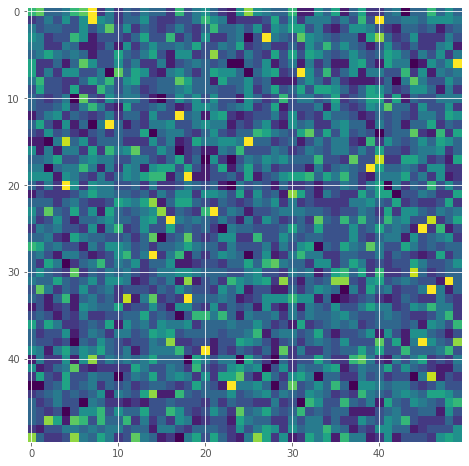

In [171]:
showField()

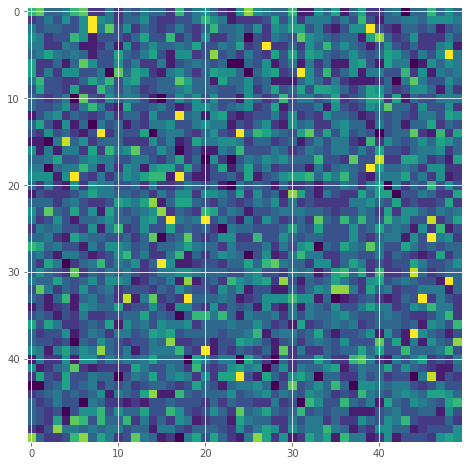

In [172]:
movePreds()
moveCarns()
showField()

---

### Применение Redis для выгрузки данных и синхронизации потоков

Попробуем выгрузить сайтов Lenta.ru и N+1 с использованием Redis в качестве центральной точки координирующей действия разных потоков работ (возможно, расположенных на разных компьютерах).  
У нас будет два потока для параллельного скачивания двух сайтов, один поток для разделения выгруженных текстов на слова, один поток для морфологического анализа, один поток для "применения" данных (получить и уничтожить).  
Каждый поток при запуске будет регистрироваться как исполнитель по данному виду работ. Далее он будет получать данные при помощи блокирующей операции от предыдущего этапа. Если получение данных не прошло за время таймаута, надо проверить, остались ли работники на предыдущем этапе. Если работников нет, необходимо прекратить свою работу и отчитаться об этом.

In [173]:
import json
import requests
import pymorphy2
import re
from bs4 import BeautifulSoup
from lxml import html
import multiprocessing
import datetime
from time import sleep
import redis

In [174]:
# Функция для загрузки одной новости из Ленты.ру
# def getLentaArticle(url):
#     """ getLentaArticle gets the body of the article from Lenta.ru"""
#     print("downloading lenta:", url)
#     r = requests.get(url)
#     p = BeautifulSoup(r.text, "html5")("p")
#     if len(p) == 0:
#         return "  "
#     p = " ".join([a.get_text() for a in p])
#     return p

def getArticleLenta(adr: str) -> str:
    ''' Загружает с сайта lenta.ru всю статью, задаваемую http-адресом adr.
    '''
    page = requests.get(adr)
    tree = html.fromstring(page.text)
    text = '\n'.join([p.text_content() for p in tree.xpath(".//p[contains(@class,'topic-body__content-text')]")])
    
    return text

def getDayArticles(r: redis.Redis, adr: str):
    ''' Загружает с сайта lenta.ru все статьи за день, задаваемый http-адресом adr.
    '''
    print('lenta '+adr)
    day = requests.get(adr)
    tree = html.fromstring(day.text)
    body = tree.xpath(".//a[@class='titles']")
    links = ['https://lenta.ru' + x.attrib["href"] for x in body]
    for link in links[:10]: # идем по первым 10 ссылкам на новости за день.
        news = getArticleLenta(link)
        if news != '':
            r.rpush("downloaded news", news)
        sleep(0.2)

# Функция загрузки одной новости из N+1.
def getArticleTextNPlus1(adr):
    print("downloading nplus1:", adr)
    r = requests.get(adr)
    n_text = re.split("</div>", re.split("</figure>", re.split('</article>',re.split('<article', r.text)[1])[0])[1])[1]    
    #return BeautifulSoup(n_text, "lxml").get_text()
    return BeautifulSoup(n_text, "html5").get_text()

# Загрузка новостей из Ленты.ру за некоторый период.
def getLenta():
    curdate = datetime.date(2017, 1, 16)
    findate = datetime.date(2017, 1, 16)
    res = ""
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)

# Загружаем новости до конечной даты.
    cnt = 0 # Очень скучно ждать, ограничим число новостей.
    while curdate <= findate:
        print('lenta ' + curdate.strftime('%Y/%m/%d'))
        getDayArticles(r, 'https://lenta.ru/news/' + curdate.strftime('%Y/%m/%d'))
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("lenta finished")

# Получаем новости с NPlus1 за заданный промежуток времени, кладем тексты новостей в очередь qu.
# По завершении взводим семафор sem.
def getNplus1():
    curdate = datetime.date(2015, 12, 15)
    findate = datetime.date(2015, 12, 16)
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)
    cnt = 0
    while curdate <= findate: # Перебираем все дни.
        r = requests.get('https://nplus1.ru/news/'+curdate.strftime('%Y/%m/%d'))
        print('nplus ' + curdate.strftime('%Y/%m/%d'))
        # Берем заголовки и ссылки на новости за этот день.
        refs = [re.split('"', t)[6] for t in re.split('<article class="item item-news item-news', r.text)[1:]]
        for t in refs:
            news = getArticleTextNPlus1("https://nplus1.ru" + t)
            if news != "  ":
                redi.rpush("downloaded news", news)
            sleep(0.2) # Мы этичные хакеры и не стремимся к DDoS.
            cnt += 1
            if cnt > 10:
                break
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("nplus1 finished")
    
# Функция токенизирует вход из очереди qu1 и кладет результаты токенизации в очередь qu2.
# Токенизация ведется до тех пор, пока семафор semw не будет взведен максимальное количество раз.
# По завершении токенизации устанавливаем событие evs.
def tokenize():  
    redi = redis.Redis()
    redi.incrby("tokenizers", 1)
    
    c = 0
    while True: 
        news = redi.blpop("downloaded news", 1)
        if news == None:
            nd = redi.get("downloaders")
            if nd == None or int(nd) == 0:
                break
            else:
                continue
                
        c += 1
        print('tokenizer ' + str(c))
        res = [n[0] for n in re.findall("([А-Яа-я]+(-[А-Яа-я]+)*)", news[1].decode())]
        news = redi.rpush("tagged news", json.dumps(res))
        
    redi.incrby("tokenizers", -1)
    print("tokenization finished")

def lemmatize():
    redi = redis.Redis()
    redi.incrby("lemmatizers", 1)

    morpho = pymorphy2.MorphAnalyzer() # Создаем морфоанализатор.
    l = []
    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("tagged news", 1)
        if news == None:
            nd = redi.get("tokenizers")
            if int(nd) == 0:
                break
            else:
                continue

        # blpop возвращает пару: имя списка, значение.
        txt = json.loads(news[1].decode())
        s = []
        for w in txt:
            s += morpho.parse(w)[0]
            
        res = json.dumps(str(s))
        redi.rpush("lemmatized news", res)
        c += 1
        print('lemma', c)
    redi.incrby("lemmatizers", -1)
    print("lemmatization finished")

# Функция имитирует, что она обрабатывает данные из очереди qu. Заершает работу по событию ev.    
def utilize():
    redi = redis.Redis()

    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("lemmatized news", 1)
        if news == None:
            nd = redi.get("lemmatizers")
            if int(nd) == 0:
                break
            else:
                continue
                
        #processing
        c += 1
        print('process', c)
    print('processing finished')


In [175]:
r = redis.Redis()

In [176]:
r.flushdb()

True

In [177]:
r.set('downloaders', 0)
r.set('tokenizers', 0)
r.set('lemmatizers', 0)

lentap = multiprocessing.Process(target=getLenta)
nplusp = multiprocessing.Process(target=getNplus1)  
tokenp = multiprocessing.Process(target=tokenize)   
lemmap = multiprocessing.Process(target=lemmatize)   
processp = multiprocessing.Process(target=utilize)    


# Стартуем процессы    
lentap.start()
nplusp.start()
sleep(0.1)
tokenp.start()
sleep(0.1)
lemmap.start()
sleep(0.1)
processp.start()
show_redis_data(r)

# Если надо - ждем пока процессы не завершатся.
#lentap.join()
#nplusp.join()
#tokenp.join()
#lemmap.join()
#processp.join()
#print("Everything is allright")                               
                               

lenta 2017/01/16
lenta https://lenta.ru/news/2017/01/16


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">lemmatizers</td><td style="padding:3px;…

lenta finished
nplus 2015/12/15
nplus 2015/12/16
nplus 2015/12/17
nplus 2015/12/18
nplus 2015/12/19
nplus1 finished
tokenization finished
lemmatization finished
processing finished


In [179]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">lemmatizers</td><td style="padding:3px;…